## Zadanie

Zadanie polega na przewidywaniu liczby wypożyczonych rowerów/hulajnóg w danym mieście. Do dyspozycji mamy informacje historyczne na temat tego, ile pojazdów zostało wypożyczonych o danej godzinie danego dnia, jakie były wtedy warunki atmosferyczne, czy był to zwykły dzień pracy czy wolny itp. Interesuje mnie wartość ostatniej kolumny ze zbioru data.csv czyli cnt - to jest sumaryczna liczba wypożyczeń. Dodatkowo ta suma jest rozbita na liczbę wypożyczeń użytkowników zarejestrowanych (registered) i niezarejestrowanych (casual). Jeżeli ktoś chce to może stworzyć osobny model per grupa użytkowników co może poprawić wyniki. Na koniec proszę zwrócić sumaryczną liczbę wypożyczeń, czyli przewidywane registered + przewidywane casual lub przewidywane cnt.


W ramach rozwiązania proszę oddać archiwum .zip z kodem (w formie notebooka, lub skryptu/skryptów .py) oraz plikiem csv z predykcjami na zbiorze evaluation_data.csv (proszę zwrócić uwagę że nie ma tam wartości registered/casual/cnt). W ramach predykcji proszę zapisać przewidywaną wartość cnt (może to być wartość ciągła).
Końcowe wyniki obliczał będę w oparciu o błąd RMSLE - sposób ewaluacji z przykładowym plikiem csv w takiej formie której oczekuję od Państwa (muchomorki.csv) znajduje się w pliku RMSLE Calculation.ipynb.
Bardzo proszę nazywać wszystkie pliki nazwiskami autorów (najlepiej alfabetycznie), lub nazwą zespołu, nazwę plików prosze rozpocząć od przedrostka poniedzialek_ lub piatek_.

Proszę upewnić się że plik csv z predykcjami na pewno ma sens - czy jest tyle wartości ile wierszy w pliku ewaluacyjnym, czy nie ma dodatkowego nagłówka, dodatkowej kolumny z indeksem itp.

## Import bibliotek

In [921]:
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [922]:
seed = 42

torch.manual_seed(seed)
np.random.seed(seed)

## Helper functions

- Saving data

In [923]:
def save_to_csv(numpy_array, filename):
    np.savetxt(filename, numpy_array, delimiter=",", fmt='%1.5f')

- Loss functions

In [924]:
def rmsle(y_true, y_pred):
    n = len(y_true)
    msle = np.mean([(np.log(max(y_pred[i],0) + 1) - np.log(y_true[i] + 1)) ** 2.0 for i in range(n)])
    return np.sqrt(msle)

In [925]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))


class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(torch.log(y_pred + 1), torch.log(y_true + 1)))

## Loading data

In [926]:
train_data = 'data.csv'
evaluation_data = 'evaluation_data.csv'

In [927]:
df_train = pd.read_csv(train_data)
df_train.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [928]:
df_train.shape

(10886, 17)

In [929]:
df_train

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,17089,2012-12-19,4,1,12,19,0,3,1,1,0.38,0.3939,0.50,0.3881,7,329,336
10882,17090,2012-12-19,4,1,12,20,0,3,1,1,0.36,0.3485,0.57,0.2239,10,231,241
10883,17091,2012-12-19,4,1,12,21,0,3,1,1,0.34,0.3182,0.61,0.2239,4,164,168
10884,17092,2012-12-19,4,1,12,22,0,3,1,1,0.34,0.3485,0.61,0.0896,12,117,129


In [930]:
df_train.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [931]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     10886 non-null  int64  
 1   dteday      10886 non-null  object 
 2   season      10886 non-null  int64  
 3   yr          10886 non-null  int64  
 4   mnth        10886 non-null  int64  
 5   hr          10886 non-null  int64  
 6   holiday     10886 non-null  int64  
 7   weekday     10886 non-null  int64  
 8   workingday  10886 non-null  int64  
 9   weathersit  10886 non-null  int64  
 10  temp        10886 non-null  float64
 11  atemp       10886 non-null  float64
 12  hum         10886 non-null  float64
 13  windspeed   10886 non-null  float64
 14  casual      10886 non-null  int64  
 15  registered  10886 non-null  int64  
 16  cnt         10886 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 1.4+ MB


In [932]:
df_train.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,8537.421183,2.506614,0.501929,6.521495,11.541613,0.028569,2.998622,0.680875,1.418427,0.493436,0.473102,0.618865,0.191036,36.021955,155.552177,191.574132
std,5026.363303,1.116174,0.500019,3.444373,6.915838,0.166599,2.007770,0.466159,0.633839,0.190039,0.169492,0.192450,0.121859,49.960477,151.039033,181.144454
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.015200,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4282.250000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,4.000000,36.000000,42.000000
50%,8666.500000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.620000,0.194000,17.000000,118.000000,145.000000
75%,13016.750000,4.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.640000,0.621200,0.770000,0.253700,49.000000,222.000000,284.000000
max,17093.000000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,0.909100,1.000000,0.850700,367.000000,886.000000,977.000000


## Cleaning data

In [933]:
df_train.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [934]:
df_train_clean = df_train.copy()

In [935]:
df_train_clean['dteday'] = pd.to_datetime(df_train_clean['dteday'])
df_train_clean.dtypes

instant                int64
dteday        datetime64[ns]
season                 int64
yr                     int64
mnth                   int64
hr                     int64
holiday                int64
weekday                int64
workingday             int64
weathersit             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object

In [936]:
df_train_clean.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [937]:
df_train_clean['day'] = df_train_clean['dteday'].dt.day

In [938]:
df_train_clean.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,1
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,1
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,1
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,1
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,1


In [939]:
feature_columns = ['season', 'day', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
                            'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']

In [940]:
df_train_clean

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16,1
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40,1
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32,1
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13,1
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,17089,2012-12-19,4,1,12,19,0,3,1,1,0.38,0.3939,0.50,0.3881,7,329,336,19
10882,17090,2012-12-19,4,1,12,20,0,3,1,1,0.36,0.3485,0.57,0.2239,10,231,241,19
10883,17091,2012-12-19,4,1,12,21,0,3,1,1,0.34,0.3182,0.61,0.2239,4,164,168,19
10884,17092,2012-12-19,4,1,12,22,0,3,1,1,0.34,0.3485,0.61,0.0896,12,117,129,19


In [941]:
y_data = df_train_clean['cnt']
y_data.head()

0    16
1    40
2    32
3    13
4     1
Name: cnt, dtype: int64

In [942]:
df_train_clean = df_train_clean[feature_columns]
df_train_clean.head()

,season,day,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,1,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0
1,1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0
2,1,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0
3,1,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0
4,1,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0


In [943]:
input_features = len(df_train_clean.columns)
input_features

13

## Data cleaning and transformation

In [944]:
train_data = df_train.sample(frac=0.8, random_state=200) #random state is a seed value
val_data = df_train.drop(train_data.index)

In [945]:
class DataTransformer:
    def __init__(self, feature_columns):
        self.feature_columns = feature_columns

    def fit_transform(self, X):
        df_train_clean = X.copy()
        df_train_clean['dteday'] = pd.to_datetime(df_train_clean['dteday'])
        df_train_clean['day'] = df_train_clean['dteday'].dt.day
        
        y = df_train_clean['cnt'].values.reshape(-1, 1)
        X = df_train_clean[self.feature_columns]
        return torch.tensor(X.values, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

    def transform(self, X):
        return self.fit_transform(X)
    
    def transform_test(self, X):
        df_train_clean = X.copy()
        df_train_clean['dteday'] = pd.to_datetime(df_train_clean['dteday'])
        df_train_clean['day'] = df_train_clean['dteday'].dt.day
        
        X = df_train_clean[self.feature_columns]
        return torch.tensor(X.values, dtype=torch.float32)

In [946]:
data_transformer = DataTransformer(feature_columns)

In [947]:
X, y = data_transformer.fit_transform(train_data)
X.shape, y.shape

(torch.Size([8709, 13]), torch.Size([8709, 1]))

In [948]:
X_val, y_val = data_transformer.transform(val_data)
X_val.shape, y_val.shape

(torch.Size([2177, 13]), torch.Size([2177, 1]))

## Dataset and DataLoader

In [949]:
class RentDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [950]:
train_dataset = RentDataset(X, y)
val_dataset = RentDataset(X_val, y_val)

In [951]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64)

## Model

In [952]:
class RegressionModel(nn.Module):
    def __init__(self, input_features, hidden_1, hidden_2, hidden_3, output_features, device='cpu') -> None:
        super().__init__()
        self.device = device
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_features, hidden_1),
            nn.ReLU(),
            nn.Linear(hidden_1, hidden_2),
            nn.ReLU(),
            nn.Linear(hidden_2, hidden_3),
            nn.ReLU()
        )
        self.dropout = nn.Dropout(0.25)
        self.output_layer = nn.Linear(hidden_3, output_features)

    def forward(self, x):
        x = self.linear_relu_stack(x)
        x = self.dropout(x)
        x = self.output_layer(x)
        return x
    
    def predict(self, x):
        y_pred = self.forward(x)
        return [torch.max(pred, 0)[0].item() for pred in y_pred]
    
    def fit(self, train_dataloader, loss_func, optimizer, epochs, val_dataloader=None):
        train_report = {
            'train_loss_history': []
        }
        
        if val_dataloader is not None:
            train_report['val_loss_history'] = []
        
        self.train()
        for epoch in range(epochs):
            train_epoch_loss = self.__train_one_epoch(train_dataloader, loss_func, optimizer)
              
            avg_epoch_loss = train_epoch_loss / len(train_dataloader)
            train_report['train_loss_history'].append(avg_epoch_loss)
            print('================================')
            print(f'Epoch: {epoch}, Train Loss: {avg_epoch_loss}')
            
            if val_dataloader is not None:
                val_loss = self.perform_validation(val_dataloader, loss_func)
                train_report['val_loss_history'].append(val_loss)
                print(f'Val Loss: {val_loss}')
            
        return train_report

    def perform_validation(self, validation_dataloader, loss_func):
        val_loss = 0.0
        with torch.no_grad():
            for sample_batch, label_batch in validation_dataloader:
                x = sample_batch.to(self.device)
                y = label_batch.to(self.device)
                
                y_pred = self.forward(x)
                loss = loss_func(y_pred, y)
                val_loss += loss.item()
            
            avg_val_loss = val_loss / len(validation_dataloader)
        return avg_val_loss

    def __train_one_epoch(self, train_dataloader, loss_func, optimizer):
        train_epoch_loss = 0.0
        for sample_batch, label_batch in train_dataloader:
                X = sample_batch.to(self.device)
                y = label_batch.to(self.device)
                
                y_pred = self.forward(X)
                loss = loss_func(y_pred, y)
                train_epoch_loss += loss.item()
                
                self.__optimize_params(loss, optimizer)
        return train_epoch_loss

    def __optimize_params(self, loss, optimizer):
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


## Training

In [953]:
model = RegressionModel(input_features, 128, 64, 32, 1)
model

RegressionModel(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=13, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
)

In [954]:
# loss_func = nn.MSELoss()
# loss_func = rmsle
loss_func = RMSELoss()
# loss_func = RMSLELoss()


In [955]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0015)

In [956]:
train_report = model.fit(train_dataloader, loss_func, optimizer, epochs=100, val_dataloader=val_dataloader)

Epoch: 0, Train Loss: 174.76955039335257
Val Loss: 150.5278518676758
Epoch: 1, Train Loss: 148.6290031405159
Val Loss: 135.6022755214146
Epoch: 2, Train Loss: 134.86897711002783
Val Loss: 127.23593630109515
Epoch: 3, Train Loss: 129.61093019478486
Val Loss: 122.1980732509068
Epoch: 4, Train Loss: 125.69934385250777
Val Loss: 119.45140980311803
Epoch: 5, Train Loss: 124.41823505219959
Val Loss: 121.7746447971889
Epoch: 6, Train Loss: 122.81619547749614
Val Loss: 119.52277014596122
Epoch: 7, Train Loss: 121.87626872918544
Val Loss: 119.2218171255929
Epoch: 8, Train Loss: 120.18879979172033
Val Loss: 119.2489884512765
Epoch: 9, Train Loss: 117.75261566665147
Val Loss: 120.27307564871651
Epoch: 10, Train Loss: 116.10211248712226
Val Loss: 117.91680276053292
Epoch: 11, Train Loss: 114.52005966242416
Val Loss: 110.85872105189732
Epoch: 12, Train Loss: 112.40888562045255
Val Loss: 110.86725823538644
Epoch: 13, Train Loss: 108.5246225294176
Val Loss: 104.89034500122071
Epoch: 14, Train Loss: 1

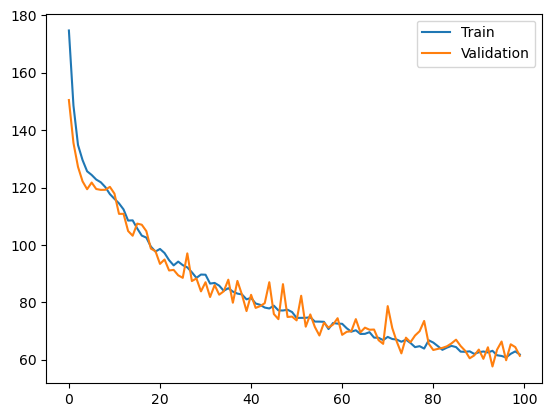

In [957]:
plt.plot(train_report['train_loss_history'], label='Train')
plt.plot(train_report['val_loss_history'], label='Validation')
plt.legend()


## Testing

In [958]:
df_test = pd.read_csv(evaluation_data)
df_test.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-20,1,0,1,0,0,4,1,1,0.26,0.2273,0.56,0.3881
1,2011-01-20,1,0,1,1,0,4,1,1,0.26,0.2727,0.56,0.0000
2,2011-01-20,1,0,1,2,0,4,1,1,0.26,0.2727,0.56,0.0000
3,2011-01-20,1,0,1,3,0,4,1,1,0.26,0.2576,0.56,0.1642
4,2011-01-20,1,0,1,4,0,4,1,1,0.26,0.2576,0.56,0.1642


In [959]:
X_test = data_transformer.transform_test(df_test)
X_test.shape

torch.Size([6493, 13])

In [960]:
y_pred = model.predict(X_test)
y_pred

[11.971623420715332,
 10.813616752624512,
 10.813616752624512,
 10.813616752624512,
 10.813616752624512,
 10.813616752624512,
 29.467273712158203,
 95.57715606689453,
 227.04530334472656,
 108.7562026977539,
 99.20986938476562,
 122.470703125,
 137.6605987548828,
 68.01746368408203,
 79.76946258544922,
 92.34030151367188,
 143.4764404296875,
 181.70376586914062,
 99.01524353027344,
 147.2304229736328,
 132.79759216308594,
 57.36481857299805,
 67.07674407958984,
 48.961483001708984,
 12.489407539367676,
 10.813616752624512,
 10.813616752624512,
 10.813616752624512,
 10.813616752624512,
 10.813616752624512,
 10.813616752624512,
 57.25126266479492,
 146.73533630371094,
 149.56935119628906,
 126.60350036621094,
 115.4466552734375,
 110.48112487792969,
 88.25422668457031,
 90.69479370117188,
 139.7765350341797,
 128.36337280273438,
 216.15602111816406,
 123.75151062011719,
 100.79556274414062,
 64.70075225830078,
 47.545684814453125,
 40.35800552368164,
 37.57320022583008,
 29.15185546875,


In [961]:
filename = "poniedzialek_Kulesza_Tomaszewski_predictions.csv"

save_to_csv(y_pred, filename)

In [962]:
# filename = "poniedzialek_Kulesza_Tomaszewski_predictions_backup.csv"

# save_to_csv(y_pred.detach().numpy(), filename)